In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import missingno as msno
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_blobs
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

## 0. Configuration Parameters
Customizing constants for the run(s).

In [41]:
# config
np.random.seed(2123)

## 1. Datasets

### 1.0. Create or load dataset
As of now, only a toy dataset is used (3 features with 3 clusters centered around different points).

In [42]:
features, clusters = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

### 1.1. plot data

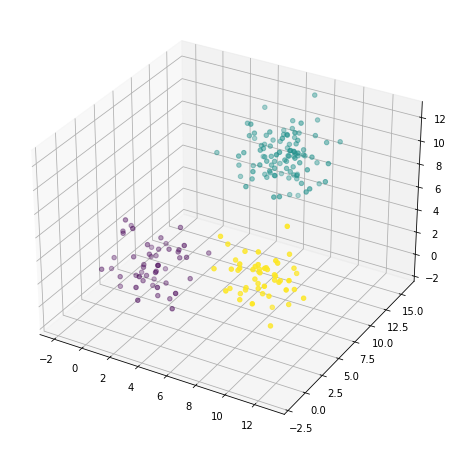

In [27]:
# plot dataset
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=clusters)
plt.show()

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [182]:
# name feature and cluster (ground truth) columns
features = pd.DataFrame(features, columns=[f"F{x + 1}" for x in range(features.shape[1])])
clusters = pd.DataFrame(clusters, columns=["C"])

# create missing values in feature column(s)
mv_percent = [0, 15, 10]  # percentages of missing values created in the feature columns
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), mv_percent)}

features_mv = features.copy()
for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv / 100)

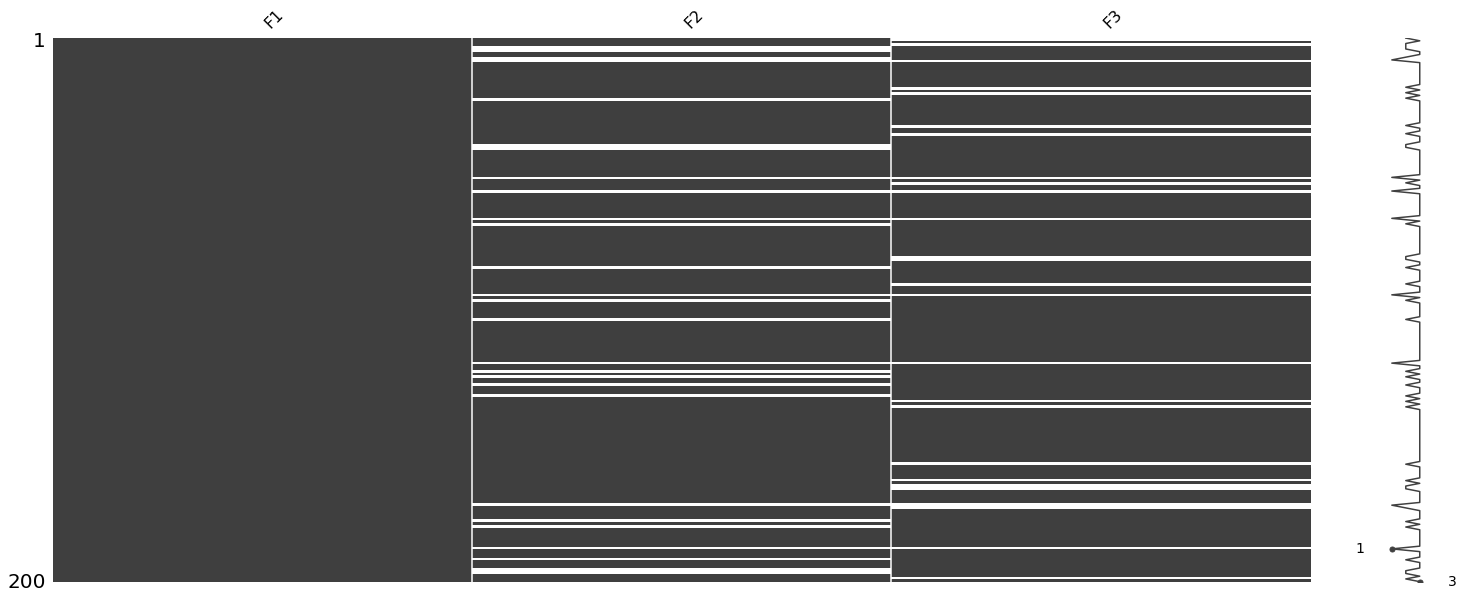

In [206]:
# plot missing values
msno.matrix(features_mv)
plt.show()

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [237]:
dbscan = DBSCAN(eps=3, min_samples=5).fit(features)
clusters = dbscan.labels_

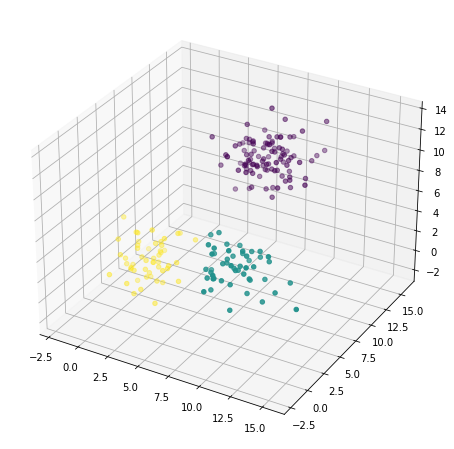

In [238]:
# plot clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters)
plt.show()

In [242]:
# get cluster means
complete_data = features
complete_data["C"] = clusters
cluster_means = complete_data.groupby("C").agg("mean")


,F1,F2,F3
C,,,
0,6.978816,12.022542,8.945462
1,10.177386,1.523312,5.318522
2,1.021275,4.907212,0.857465


## 2. Filling Strategies
Fill missing values (here with TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; Problem: Still one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

Approach 3:\


In [ ]:
# define custom loss function: extend L2-loss by cluster-mean-loss and boundary-loss
def loss_func():
    pass

In [220]:
features_filled = features_mv.copy()

for feature in features_mv.columns[features_mv.isnull().any()]:
    print(feature)
    
    # mask other columns' missing values as -1
    features_mv_masked = features_mv.copy()
    other_features = [col for col in features_mv.columns if col != feature]
    features_mv_masked[other_features] = features_mv_masked[other_features].fillna(-1)

    # separate complete rows as train data
    # separate column with missing values as target
    missing_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
    train_data = features_mv_masked[features_mv_masked[feature].notna()]
    train_features = train_data.drop(columns=feature).to_numpy()
    train_target = train_data[feature].to_numpy().reshape(-1,1)
    
    x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)
    
    # create & train model
    model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                        optimizer_params=dict(lr=2e-2),
                        scheduler_params={"step_size": 50, "gamma": 0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type='entmax')

    model.fit(
        x_train, y_train,
        eval_set=[(x_val, y_val)],
        eval_metric=['rmse'],
        max_epochs=100, patience=20,
    )
    
    # fill missing values with model predictions
    features_filled.loc[features_filled[feature].isna(),feature] = [x[0] for x in model.predict(missing_data)]

F2
[[ 9.41770664  8.2369269 ]
 [ 8.31334961  9.5853044 ]
 [ 5.89149019  9.18508649]
 [ 7.29070703 -1.        ]
 [ 9.07298435  5.1349561 ]
 [10.8293397   7.29121925]
 [ 7.51836411  7.87965141]
 [ 3.74743429 -1.        ]
 [ 3.73937564 -1.        ]
 [ 8.30174141 -1.        ]
 [ 6.64051933  9.01026149]
 [ 5.60063287  7.969515  ]
 [ 0.04946669 -1.        ]
 [15.44435567  3.87127917]
 [10.01526885  9.87920418]
 [ 8.93213379 -1.        ]
 [ 4.50630564  8.32250135]
 [10.60336322  4.86018958]
 [ 3.46795477  1.49314796]
 [ 6.65523346  9.79447903]
 [ 5.2039481  -1.        ]
 [ 9.07143878  7.49300403]
 [ 4.61207351  9.45727925]
 [ 2.93140699 -1.        ]
 [ 6.36219265  9.34798224]
 [ 8.16604448  7.31475769]
 [ 6.78140604  8.36789924]]
Device used : cpu
epoch 0  | loss: 51.27495| val_0_rmse: 95.59936|  0:00:00s
epoch 1  | loss: 38.36813| val_0_rmse: 92.87163|  0:00:00s
epoch 2  | loss: 26.54608| val_0_rmse: 82.41611|  0:00:00s
epoch 3  | loss: 18.75284| val_0_rmse: 75.95645|  0:00:00s
epoch 4  | lo

epoch 12 | loss: 1.27196 | val_0_rmse: 15.10823|  0:00:00s
epoch 13 | loss: 1.18182 | val_0_rmse: 13.20397|  0:00:00s
epoch 14 | loss: 1.10283 | val_0_rmse: 11.78376|  0:00:00s
epoch 15 | loss: 1.04268 | val_0_rmse: 10.79382|  0:00:00s
epoch 16 | loss: 0.96876 | val_0_rmse: 10.05985|  0:00:00s
epoch 17 | loss: 0.90612 | val_0_rmse: 9.42747 |  0:00:00s
epoch 18 | loss: 0.84175 | val_0_rmse: 9.06022 |  0:00:00s
epoch 19 | loss: 0.79539 | val_0_rmse: 9.23114 |  0:00:00s
epoch 20 | loss: 0.73811 | val_0_rmse: 9.36818 |  0:00:00s
epoch 21 | loss: 0.69672 | val_0_rmse: 9.20133 |  0:00:00s
epoch 22 | loss: 0.64712 | val_0_rmse: 8.80136 |  0:00:00s
epoch 23 | loss: 0.60164 | val_0_rmse: 8.83221 |  0:00:00s
epoch 24 | loss: 0.56714 | val_0_rmse: 9.20404 |  0:00:00s
epoch 25 | loss: 0.55491 | val_0_rmse: 9.6     |  0:00:01s
epoch 26 | loss: 0.48933 | val_0_rmse: 9.57564 |  0:00:01s
epoch 27 | loss: 0.47396 | val_0_rmse: 9.62842 |  0:00:01s
epoch 28 | loss: 0.48773 | val_0_rmse: 9.59381 |  0:00:0

## 3. Complete Dataset
Complete dataset and deviation of original dataset

In [221]:
features_filled

,F1,F2,F3
0,8.265864,13.031708,7.268530
1,9.067304,11.340618,9.692263
2,7.266311,3.162840,6.713374
3,9.417707,13.754110,8.236927
4,8.313350,13.924866,9.585304
...,...,...,...
195,8.166044,14.182239,7.314758
196,6.781406,11.409457,8.367899
197,9.383646,-0.471206,7.549884
198,10.121086,-1.678311,6.800494


In [222]:
(features_filled - features).abs().sum()

F1      0.000000
F2    163.440477
F3     71.229838
dtype: float64

## 4. Clustering

In [234]:
# apply clustering
dbscan = DBSCAN(eps=3, min_samples=5).fit(features_filled)
clusters_filled = dbscan.labels_

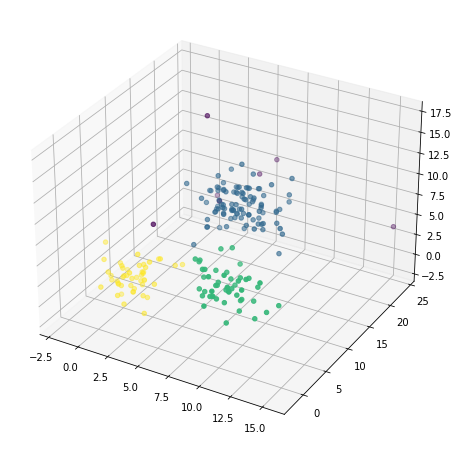

In [235]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_filled.iloc[:, 0], features_filled.iloc[:, 1], features_filled.iloc[:, 2], c=clusters_filled)
plt.show()

## 5. Cluster Performance
to be implemented